# Cronh

## Librerías

In [2]:
import os
import random
import datetime

# Datos
import numpy as np
import pandas as pd

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from IPython.display import SVG

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed

from sklearn.metrics import classification_report

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

## Configuración

In [3]:
tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## Constantes

In [4]:
PATH = "../../../"

# Ruta del archivo CSV que contiene las etiquetas y rutas de las imágenes
#csv_file = PATH + "CSVs/dataset/train.csv"
#PATH_IMAGENES = PATH + "Dataset/"

# Rutas de los archivos CSV que contienen las etiquetas y rutas de las imágenes
#TRAIN_CSV = PATH + "CSVs/dataset/train.csv"
#VAL_CSV = PATH + "CSVs/dataset/val.csv"
#TEST_CSV = PATH + "CSVs/dataset/test.csv"

# Directorio de las imágenes originales
#imgs_path = PATH + "Dataset/"

# Directorio donde se almacenarán las imágenes divididas
split_path = PATH + "Vegetables Dataset/"
train_dir = split_path + "train/"
val_dir = split_path + "val/"
test_dir = split_path + "test/"

Data = "Vegetables/"

In [5]:
# Preprocesamiento
BATCH_SIZE = 32

TARGET_IMG_WIDTH = 224
TARGET_IMG_HEIGHT = 224
TARGET_IMG_CHANNELS = 3
TARGET_SIZE = [TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT]
TARGET_SHAPE = [TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT, TARGET_IMG_CHANNELS]

NUM_EPOCHS = 100

# Modelo
MODEL_NAME = "Cronh"

CHECKPOINT_MONITOR = 'val_accuracy'
CHECKPOINT_MODE = 'max'

EARLYSTOP_MONITOR = 'val_loss'
EARLYSTOP_PATIENCE = 25 # int(NUM_EPOCHS/4)

LR_MONITOR = 'val_loss'
LR_FACTOR = 0.5
LR_PATIENCE = 10 # int(NUM_EPOCHS / 10)
LR_MINLR = 0.0001

NUM_CLASSES = 15

INITIAL_WEIGHTS = 'imagenet'

# Train
OPTIMIZER = "adam"
LOSS = 'sparse_categorical_crossentropy'
METRICS = ["accuracy"]

In [6]:
# Obtener la fecha y hora actual
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M")

### Callback

#### ModelCheckpoint

**ModelCheckpoint** guardará los modelos en cada época donde se cumpla la condición **val_accuracy sea el máximo alcanzado hasta el momento**

In [7]:
# Definir el patrón de nombres para los archivos de modelos guardados
checkpoint_filename = f"best_model_{current_datetime}_val_acc_{{val_accuracy:.4f}}.h5"

# Combinar el directorio y el patrón de nombres
checkpoint_path = PATH + "Models/" + MODEL_NAME + "/" + Data + checkpoint_filename

# Definir el callback ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor=CHECKPOINT_MONITOR,
    mode=CHECKPOINT_MODE,
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#### Early Stopping

**EarlyStopping**: Detiene el entrenamiento si no se observa una mejora en la métrica especificada durante un número determinado de épocas consecutivas. Ayuda a evitar el overfitting y a ahorrar tiempo de entrenamiento.

In [8]:
# Definir Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=EARLYSTOP_MONITOR,
    patience=EARLYSTOP_PATIENCE,
    restore_best_weights=True
)

#### ReduceLROnPlateau

**ReduceLROnPlateau**: Reduce la tasa de aprendizaje (learning rate) cuando una métrica monitoreada deja de mejorar. Esto puede ayudar a ajustar mejor el modelo durante el entrenamiento y mejorar su convergencia.

- monitor: la métrica a monitorear
- factor: el factor de reducción del learning rate
- patience: el número de épocas sin mejora antes de reducir el learning rate
- mode: si se debe maximizar o minimizar la métrica

In [9]:
# Definir ReduceLROnPlateau
# Politicas de LR
reduce_lr = ReduceLROnPlateau(
    monitor=LR_MONITOR,
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    min_lr=LR_MINLR,
    verbose = 1)
# monitor = mean_absolute_error

#### TensorBoard

**TensorBoard**: Permite visualizar métricas, gráficas y otros detalles del entrenamiento en TensorBoard, una herramienta de visualización de TensorFlow. Proporciona una interfaz gráfica para analizar y comparar los resultados del entrenamiento a lo largo del tiempo.

In [10]:
# Definir TensorBoard
log_dir = PATH + "Logs/" + MODEL_NAME + "/" + Data
# tensorboard = TensorBoard(log_dir=log_dir)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    embeddings_freq=1,
    )

# Una vez iniciado el entrenamiento, en la terminal ejecutar:
# tensorboard --logdir=/content/drive/MyDrive/NeuralNetwork/logs/
# tensorboard --logdir=Logs/MobileNetV2/

#### CSVLogger

**CSVLogger**: Registra las métricas de entrenamiento y validación en un archivo CSV. Permite realizar un seguimiento de las métricas a lo largo del tiempo y analizarlas posteriormente.

In [11]:
# Definir CSVLogger

# Definir el nombre del archivo con la fecha incluida
csvlogger_filename = PATH + "CSVLogs/" + MODEL_NAME + "/" + Data + current_datetime + "_training.log"

csv_logger = CSVLogger(filename=csvlogger_filename)

In [12]:
CALLBACKS = [early_stopping, checkpoint, reduce_lr, tensorboard, csv_logger]

## Funciones Auxiliares

In [13]:
def plot_training(csvlogger):
    # Cargar los datos del archivo CSV
    log_data = pd.read_csv(csvlogger)

    # Graficar la pérdida y la precisión
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(log_data['epoch'], log_data['loss'], label='Training Loss')
    plt.plot(log_data['epoch'], log_data['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(log_data['epoch'], log_data['accuracy'], label='Training Accuracy')
    plt.plot(log_data['epoch'], log_data['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

# Clases verticales -> cada fila es una clase real
# Clases horizontales -> clase predicha por el modelo
def NotShuffled_ConfusionMatrix(y_pred, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

def plot_image(pred_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("Clase: {} | Pred: {} {:2.0f}%".format(class_names[true_label],
                                                class_names[predicted_label],
                                                100 * np.max(pred_array)),
                                                color=color)

def plot_predictions(y_pred, ds):
    true_categories = tf.concat([y for x, y in ds], axis=0)
    images = tf.concat([x for x, y in ds], axis=0)
    class_names = test_data.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 15)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(4*num_cols, 2*num_rows))
    for i,index in enumerate(indices):
      plt.subplot(num_rows, num_cols, i+1)
      plot_image(y_pred[index], true_categories[index], images[index],class_names)
    plt.tight_layout()
    plt.show()

def save_report(y_pred, ds, name = ""):
    y_pred_bool = np.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    report = classification_report(true_categories, y_pred_bool, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_excel(PATH + "ClassificationReports/" + MODEL_NAME + "/" + name + "classification_report.xlsx", index=True)

## Análisis de datos

In [14]:
import glob

class_dirs = os.listdir(train_dir) # list all directories inside "train" folder

image_dict = {} # dict to store image array(key) for every class(value)

count_dict = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'../../../Vegetables Dataset/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

### Muestra del dataset

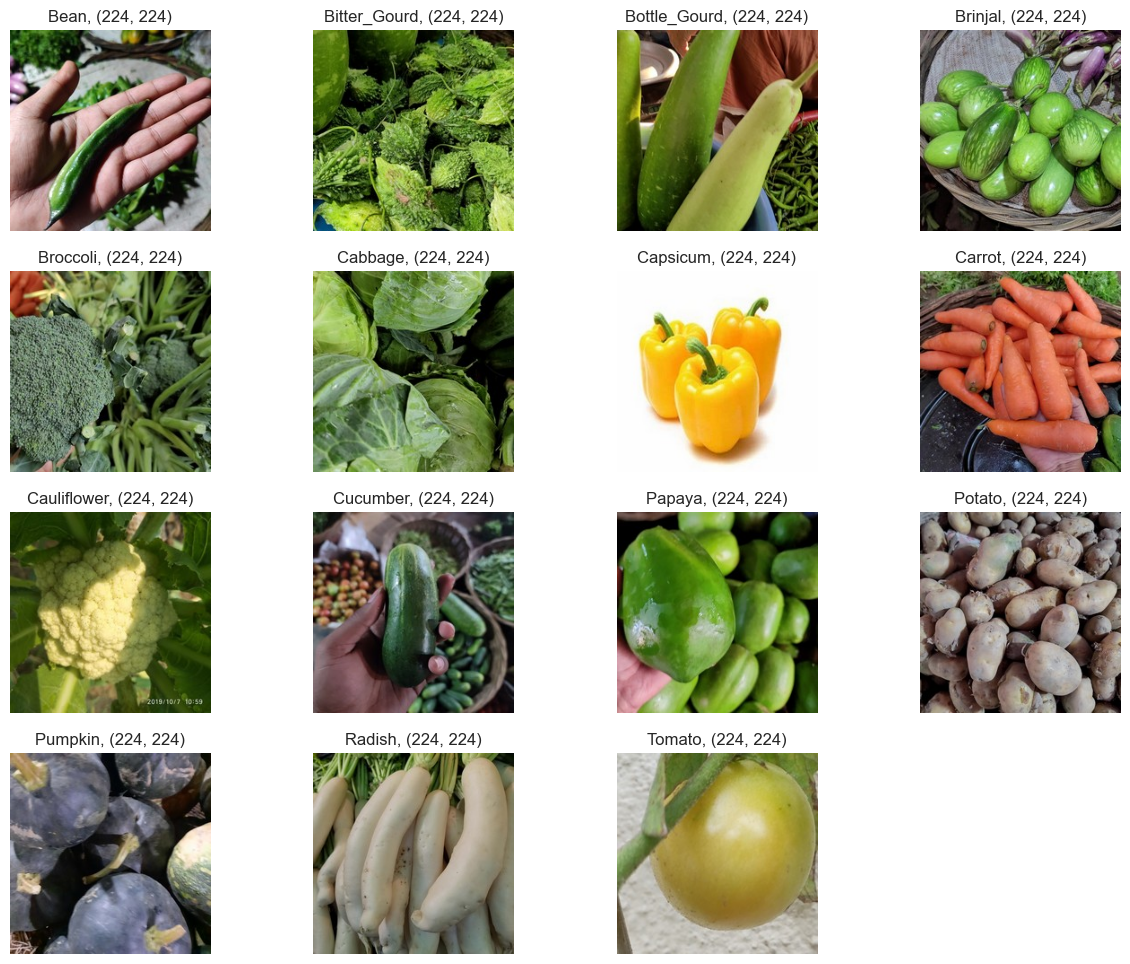

In [15]:
class_names = []

## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(4, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")
    class_names.append(cls)
    
# Ordenar alfabeticamente
class_names.sort()

### Distribución de datos

In [16]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

Count of training samples per class:
            class  count
0           Bean   1000
1   Bitter_Gourd   1000
2   Bottle_Gourd   1000
3        Brinjal   1000
4       Broccoli   1000
5        Cabbage   1000
6       Capsicum   1000
7         Carrot   1000
8    Cauliflower   1000
9       Cucumber   1000
10        Papaya   1000
11        Potato   1000
12       Pumpkin   1000
13        Radish   1000
14        Tomato   1000


<Figure size 1500x1200 with 0 Axes>

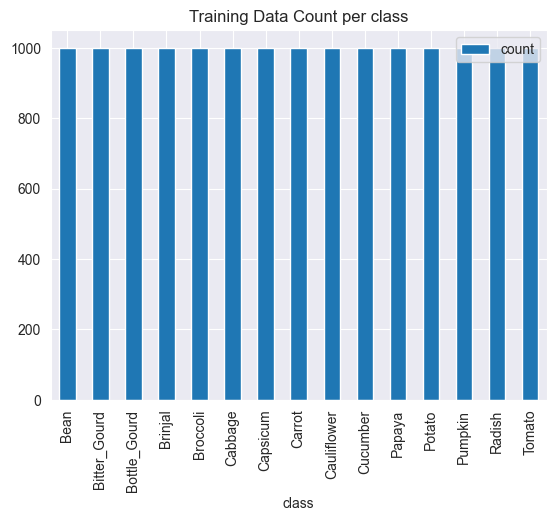

In [17]:
# draw a bar plot using pandas in-built plotting function
plt.figure(figsize=(15,12))
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class")
plt.show()

In [18]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle = True,
    # seed=SEED,
    #image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    #label_mode="categorical"
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle = False,
    # seed=SEED,
    #image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    #label_mode="categorical"
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle = False,
)


Loading Train Data...
Found 15000 files belonging to 15 classes.

Loading Validation Data...
Found 3000 files belonging to 15 classes.

Loading Test Data...
Found 3000 files belonging to 15 classes.


# Data Preprocessing

In [19]:
# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Data Processing con data augmentation
data_augmentation = keras.Sequential(
    name="data_augmentation",
    layers=[
        layers.Rescaling(1.0/255), # Value Preprocessing
        layers.Resizing(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH), # Shape Preprocessing

        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),

        tf.keras.layers.RandomContrast(factor = 0.5), # (x - mean) * contrast_factor + mean
        tf.keras.layers.RandomBrightness(factor = 0.3, value_range=(0,1)),
        tf.keras.layers.GaussianNoise(0.1),

        # tf.keras.layers.CenterCrop(50,50)
        # tf.keras.layers.RandomCrop(50,50)
        # tf.keras.layers.RandomZoom(50,50)


        tf.keras.layers.RandomTranslation(
            height_factor = 1,
            width_factor= 1,
            fill_mode='wrap',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0,
        )
    ]
)

### Data Augmentation

In [20]:
# Obtener un lote de imágenes originales del conjunto de datos
batch_images, batch_labels = next(iter(train_data))

# Aplicar el data_augmentation a cada imagen de muestra
augmented_images = data_augmentation(batch_images, training=True)

In [21]:
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

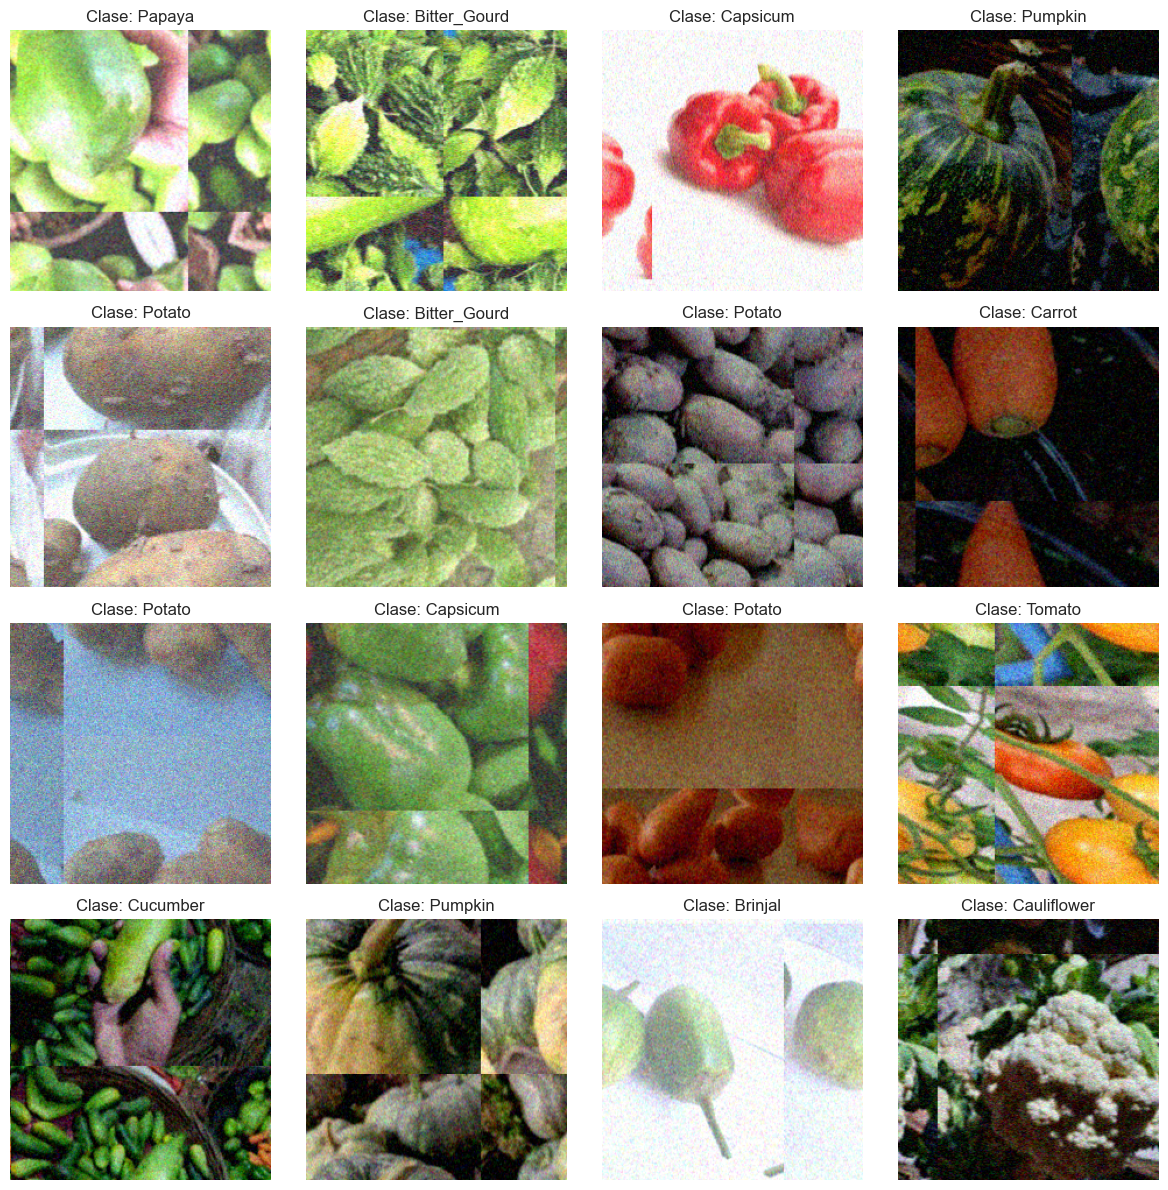

In [22]:
# Visualizar las imágenes aumentadas con sus etiquetas
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f"Clase: {class_names[batch_labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [23]:
# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_augmentation(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

# Cronh

### Modelo

In [24]:
def conv_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def conv_blocks(inputs, n_filters):
    x = conv_block(inputs, n_filters)
    x = conv_block(x, n_filters)
    x = conv_block(x, n_filters)
    return x

In [25]:
# Añadir capas
inputs = tf.keras.Input(shape=TARGET_SHAPE)

# Feature extraction blocks
x = conv_blocks(inputs, 32)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = conv_blocks(x, 48)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = conv_blocks(x, 56)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = conv_blocks(x, 64)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = conv_blocks(x, 64)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = conv_blocks(x, 96)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Classification layer
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

In [26]:
# Modelo Final
model = Model(inputs=inputs, outputs=predictions)

In [27]:
# Compilar el modelo
model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=METRICS)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                             

### Entrenamiento

In [ ]:
history_mobilenet = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=val_ds,
    callbacks=CALLBACKS)

Epoch 1/100


2023-07-10 12:29:21.786435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype resource
	 [[{{node Placeholder/_21}}]]
2023-07-10 12:29:21.787106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype resource
	 [[{{node Placeholder/_18}}]]
2023-07-10 12:29:26.642370: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2023-07-10 12:29:27.363970: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2023-07-10 12:29:27.532470: W tensorflow/tsl/framework/cpu

469/469 [==============================] - ETA: 0s - loss: 1.6819 - accuracy: 0.4285

2023-07-10 13:14:14.413367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3000]
	 [[{{node Placeholder/_4}}]]
2023-07-10 13:14:14.413793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3000]
	 [[{{node Placeholder/_4}}]]



Epoch 1: val_accuracy improved from -inf to 0.37800, saving model to ../../../Models/Cronh/Vegetables/best_model_20230710_1229_val_acc_0.3780.h5
469/469 [==============================] - 2796s 6s/step - loss: 1.6819 - accuracy: 0.4285 - val_loss: 2.8695 - val_accuracy: 0.3780 - lr: 0.0010
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 1.1217 - accuracy: 0.6313
Epoch 2: val_accuracy did not improve from 0.37800
469/469 [==============================] - 3161s 7s/step - loss: 1.1217 - accuracy: 0.6313 - val_loss: 3.9732 - val_accuracy: 0.2730 - lr: 0.0010
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.8590 - accuracy: 0.7147
Epoch 3: val_accuracy improved from 0.37800 to 0.60633, saving model to ../../../Models/Cronh/Vegetables/best_model_20230710_1229_val_acc_0.6063.h5
469/469 [==============================] - 2748s 6s/step - loss: 0.8590 - accuracy: 0.7147 - val_loss: 1.1993 - val_accuracy: 0.6063 - lr: 0.0010
Epoch 4/100
469/469 [==

469/469 [==============================] - 2464s 5s/step - loss: 0.0568 - accuracy: 0.9821 - val_loss: 0.1645 - val_accuracy: 0.9483 - lr: 5.0000e-04
Epoch 26/100
469/469 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9822
Epoch 26: val_accuracy did not improve from 0.98867
469/469 [==============================] - 2462s 5s/step - loss: 0.0590 - accuracy: 0.9822 - val_loss: 0.1558 - val_accuracy: 0.9477 - lr: 5.0000e-04
Epoch 27/100
469/469 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9816
Epoch 27: val_accuracy did not improve from 0.98867
469/469 [==============================] - 2468s 5s/step - loss: 0.0591 - accuracy: 0.9816 - val_loss: 0.1230 - val_accuracy: 0.9590 - lr: 5.0000e-04
Epoch 28/100
469/469 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9821
Epoch 28: val_accuracy did not improve from 0.98867
469/469 [==============================] - 2466s 5s/step - loss: 0.0592 - accuracy: 0.9821 - val_los

#### Resultados del entrenamiento

In [29]:
csvlogger_filename = PATH + "CSVLogs/Cronh/Vegetables/20230710_1229_training.log"

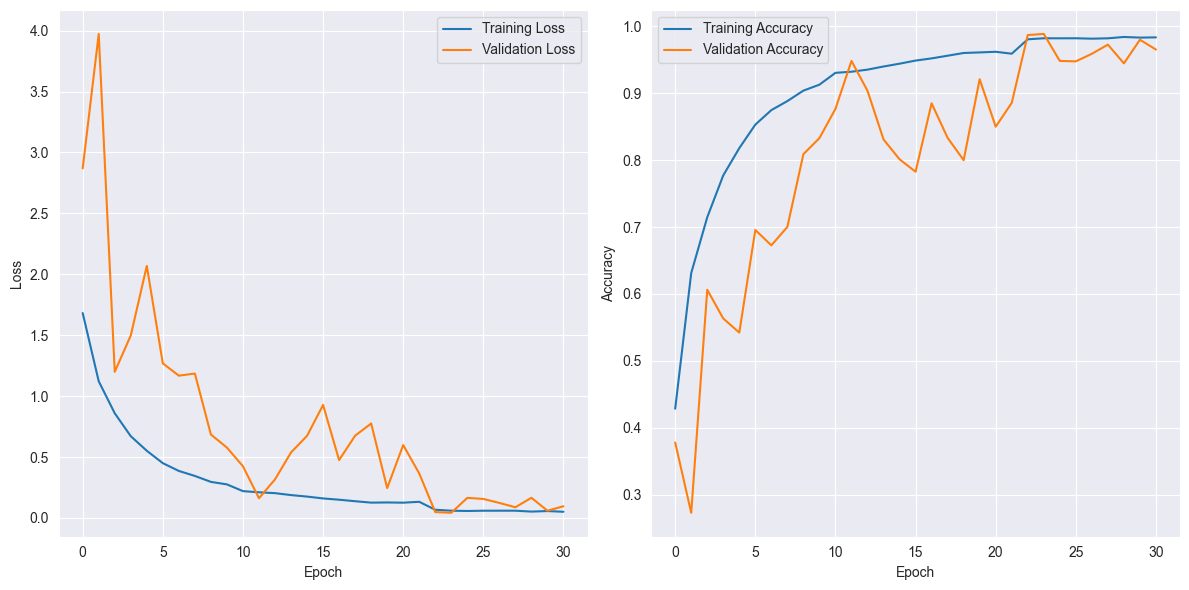

In [30]:
# Mostrar como ha ido el entrenamiento
plot_training(csvlogger_filename)

In [37]:
best_model_path = PATH + "Models/" + MODEL_NAME + "/Vegetables/best_model_20230710_1229_val_acc_0.9887.h5"
best_model = load_model(best_model_path, compile=False)

In [38]:
# Compilar el modelo
best_model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=METRICS)

In [39]:
best_model.evaluate(test_ds)

94/94 [==============================] - 83s 857ms/step - loss: 0.0437 - accuracy: 0.9880


[0.04369114339351654, 0.9879999756813049]

94/94 [==============================] - 82s 861ms/step


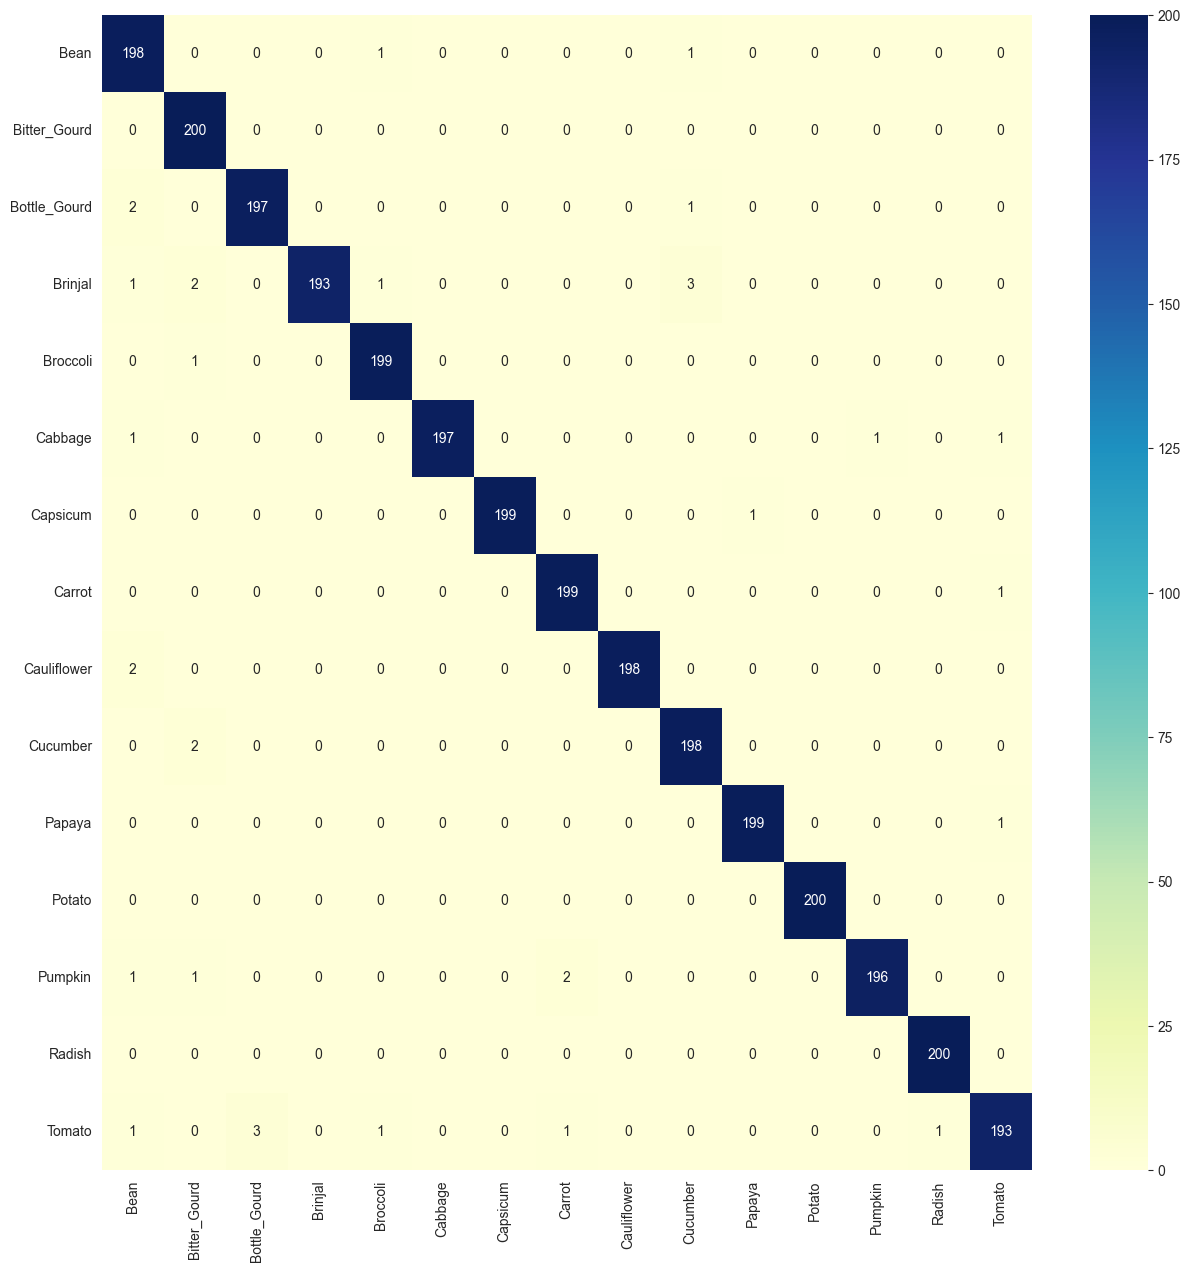

In [40]:
y_pred_val = best_model.predict(val_ds)
NotShuffled_ConfusionMatrix(y_pred_val, val_ds, val_data.class_names)

In [41]:
save_report(y_pred_val, val_ds, "val_")

94/94 [==============================] - 82s 865ms/step


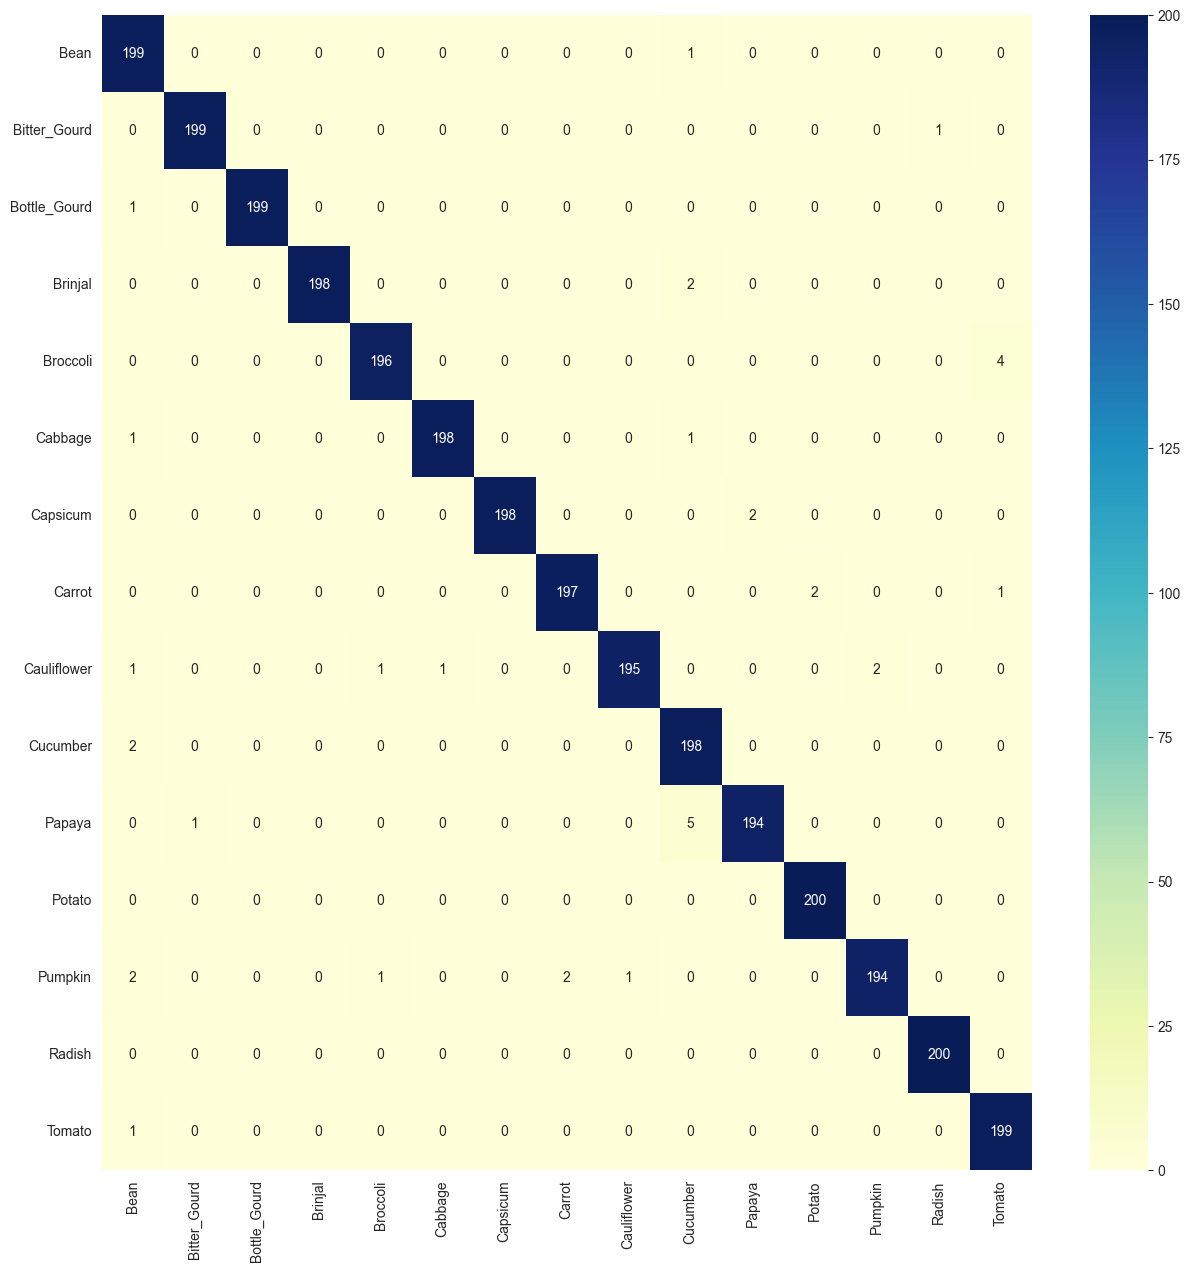

In [42]:
y_pred_test = best_model.predict(test_ds)
NotShuffled_ConfusionMatrix(y_pred_test, test_ds, test_data.class_names)

In [43]:
save_report(y_pred_test, test_ds, "test_")

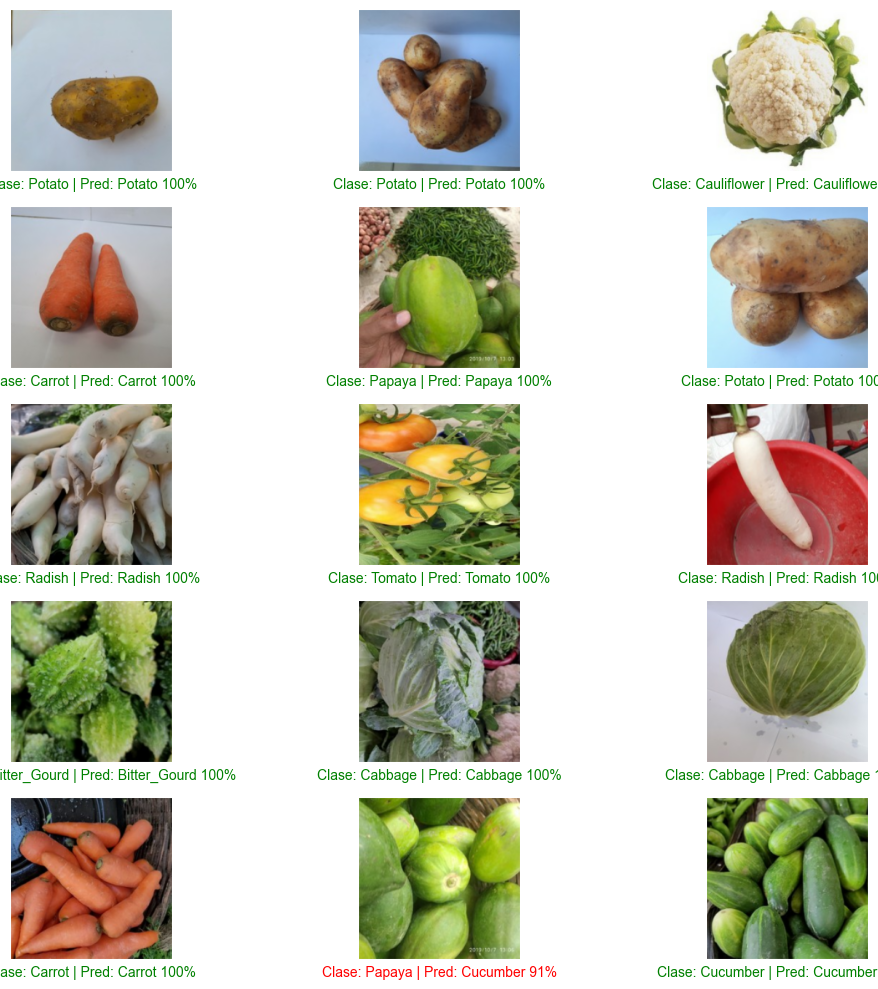

In [44]:
plot_predictions(y_pred_test, test_ds)